In [2]:
import pandas as pd
import numpy as np
import random as rn
import datetime
import re
import os
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import itertools
from tqdm import tqdm
import tqdm.notebook as tq
import matplotlib.pyplot as plt
from argparse import ArgumentParser

tqdm.pandas()

In [3]:
parser = ArgumentParser()
parser.add_argument("-r", "--run", type=int)
parser.add_argument("-i", "--iterations", type=int)
parser.add_argument("-d", "--diter", type=int)
parser.add_argument("-s", "--siter", type=int)
parser.add_argument("-z", "--size", type=int)
parser.add_argument("-n", "--rows", type=str)

args = vars(parser.parse_args())
run = args['run']
iterations = args['iterations']
diter = args['diter']
siter = args['siter']
vector_size = args['size']
no_rows = args['rows']

# run = 0
# iterations = 2
# diter = 5
# siter = 5
# vector_size = 300
# no_rows = '10000'

if no_rows.isdecimal():
    no_rows = int(no_rows)


In [4]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]

(1280918, 12)
(1274505, 12)


'παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος'

In [5]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

In [6]:
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

0    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1    παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...
2    κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...
3                                              @sw @sw
Name: speech, dtype: object

In [7]:
#New column year
df['year'] = df['sitting_date'].dt.year
df['decade'] = (df['year']//10)*10
df = df[df.decade != 1980] # remove dates before 2000 to catch the three last decades
df = df[df.decade != 2020]# remove 2020s
df = df[df.decade != 2000]# remove 2000s

df.speech = df.speech.progress_apply(lambda x: x.replace(".", " . ")) #add space around dot

print(set(df.decade.to_list()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860546/860546 [00:01<00:00, 640627.06it/s]


{2010, 1990}


In [8]:
df.columns

Index(['member_name', 'sitting_date', 'parliamentary_period',
       'parliamentary_session', 'parliamentary_sitting', 'political_party',
       'government', 'member_region', 'roles', 'member_gender', 'speaker_info',
       'speech', 'year', 'decade'],
      dtype='object')

In [9]:
df.speech = df.speech+' . '

In [10]:
print(df.speech.iloc[1])

κυριοι συναδελφοι @sw προχωρησουμε @sw ορκωμοσια @sw συναδελφου βασιλη κοραχαη . παρακαλειται @sw βασιλης κοραχαης @sw προσελθει @sw @sw ορκισθει . ορκιζομαι @sw ονομα @sw αγιας @sw ομοουσιας @sw αδιαιρετης τριαδας @sw @sw πιστος @sw πατριδα @sw @sw δημοκρατικο πολιτευμα @sw υπακουω @sw συνταγμα @sw @sw νομους @sw @sw εκπληρω ευσυνειδητα @sw καθηκοντα @sw . 


In [11]:
#concat sentences, each last sentence for each speech did not have dot so add one.
print('Preparing data...')
df.speech = df.speech.progress_apply(lambda x: x.replace('\n', ' '))
df.speech = df.speech.progress_apply(lambda x: re.sub('\s\s+' , ' ', x)) 
df.speech = df.speech.progress_apply(lambda x: x.replace('. ', '.\n'))
 
print('Group by decades...')
print(datetime.datetime.now())
PERdecade_df = df.groupby(df.decade)['speech'].progress_apply(''.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.


Preparing data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860546/860546 [00:01<00:00, 502762.95it/s]


Group by decades...
2021-09-14 21:00:55.372704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


Select subset of the data for short training and testing

In [12]:
if isinstance(no_rows, str):
    if no_rows =='all':
        pass
    else:
        print('Undefined row number')
else:

    PERdecade_df.speech[0] = PERdecade_df.speech[0][:no_rows]
    PERdecade_df.speech[1] = PERdecade_df.speech[1][:no_rows]
#     print(len(PERdecade_df.speech.iloc[0]))
#     print(len(PERdecade_df.speech.iloc[1]))
#     print(PERdecade_df.head())

/home/dina/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dina/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Insert Goldberg's frequency cut-offs

In [4]:
df_freq_1990 = pd.read_csv('../out_files/freqs_for_semantic_shift_cleaned_data_decade1990.csv')
df_freq_2010 = pd.read_csv('../out_files/freqs_for_semantic_shift_cleaned_data_decade2010.csv')

print('1990')
df_freq_1990 = df_freq_1990[df_freq_1990.word != '@sw']
print(df_freq_1990.frequency.describe().apply(lambda x: format(x, 'f')))

print('2010')
df_freq_2010 = df_freq_2010[df_freq_2010.word != '@sw']
print(df_freq_2010.frequency.describe().apply(lambda x: format(x, 'f')))

# most frequent words at the top
df_freq_1990 = df_freq_1990.sort_values('frequency', ascending=False)
df_freq_2010 = df_freq_2010.sort_values('frequency', ascending=False)

# collect 200 most frequent words
most_freq_1990 = df_freq_1990.word.head(200).to_list()
most_freq_2010 = df_freq_2010.word.head(200).to_list()

# collect words with less than 200 frequency
least_frequent_1990 = df_freq_1990.loc[df_freq_1990.frequency<200].word.to_list()
least_frequent_2010 = df_freq_2010.loc[df_freq_2010.frequency<200].word.to_list()

# # collect words with less than 100 occurrences 
# less_than_100_1990_list = df_freq_1990.loc[(df_freq_1990.frequency<100), 'word'].to_list()
# less_than_100_2010_list = df_freq_2010.loc[(df_freq_2010.frequency<100), 'word'].to_list()
# less_than_100_union = set(less_than_100_1990_list+less_than_100_2010_list)

1990
count    310325.000000
mean         66.751722
std         880.305439
min           1.000000
25%           1.000000
50%           2.000000
75%           8.000000
max      220110.000000
Name: frequency, dtype: object
2010
count    268992.000000
mean        111.124242
std        1362.758724
min           1.000000
25%           1.000000
50%           3.000000
75%          15.000000
max      277382.000000
Name: frequency, dtype: object


from word comparison remove: most_freq_1990, most_freq_2010, least_frequent_1990, least_frequent_2010
from neighbors remove: less_than_100_union

In [14]:
# this function collects words eligible for semantic shift computation
# from the intersection of the vocabularies that fulfill specific frequency thresholds
def eligible_words(iteration, m1, m2, most_freq_1990, least_frequent_1990, most_freq_2010, least_frequent_2010):

    m1_vocab = [key for key, value in m1.wv.vocab.items() if key!=' ']
    m2_vocab = [key for key, value in m2.wv.vocab.items() if key!=' ']

    intersection = set(m1_vocab).intersection(set(m2_vocab))
    most_freq = set(most_freq_1990+most_freq_2010)
    least_freq = set(least_frequent_1990+least_frequent_2010)

    # Clean words to search for usage change
    final_list = [w for w in intersection if w not in most_freq and w not in least_freq and w!='@sw']
    
    return final_list, intersection 


********************************************************
Repeat No  0
2021-09-12 00:52:50.999816
Creating training texts...


2it [00:01,  1.15it/s]


Training aligned models...
2021-09-12 00:52:52.737446


  0%|                                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

(1990, 2010)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice ../out_files/training_texts/compass_stability/1990_0.txt.
Initializing embeddings from compass.
Training embeddings: slice ../out_files/training_texts/compass_stability/2010_0.txt.
Initializing embeddings from compass.
129286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [1:01:46<00:00, 3706.70s/it]


********************************************************
Repeat No  1
2021-09-12 01:54:39.438029
Creating training texts...


2it [00:01,  1.13it/s]


Training aligned models...
2021-09-12 01:54:41.217959


  0%|                                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

(1990, 2010)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training embeddings: slice ../out_files/training_texts/compass_stability/1990_1.txt.
Initializing embeddings from compass.
Training embeddings: slice ../out_files/training_texts/compass_stability/2010_1.txt.
Initializing embeddings from compass.
129286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [1:01:05<00:00, 3665.53s/it]


           iteration  semantic_similarity  common_voc_size
count  258572.000000        258572.000000         258572.0
mean        0.500000             0.449987         129286.0
std         0.500001             0.203037              0.0
min         0.000000            -0.663032         129286.0
25%         0.000000             0.299821         129286.0
50%         0.500000             0.427700         129286.0
75%         1.000000             0.603489         129286.0
max         1.000000             0.944161         129286.0
Words with the lowest cosine similarity / highest change
        iteration   decade_pair            word  semantic_similarity  \
9700            0  (1990, 2010)            6744            -0.663032   
242097          1  (1990, 2010)            3554            -0.614936   
138986          1  (1990, 2010)            6744            -0.601879   
145677          1  (1990, 2010)            2583            -0.541551   
69718           0  (1990, 2010)            4529     

[10, 20, 50, 100, 200, 500, 1000] [0.3, 0.4, 0.58, 0.67, 0.705, 0.772, 0.778]


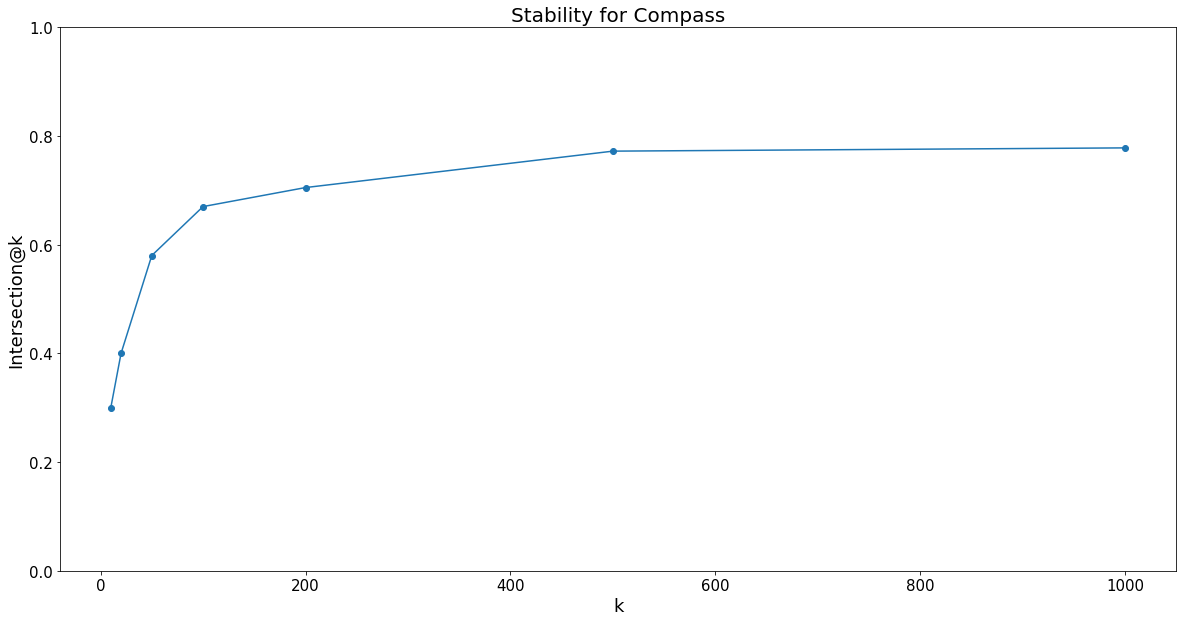

In [13]:
shifts_PERdecade_list=[]

for i in range(iterations):
    print('********************************************************')
    print('Repeat No ', str(i))

    np.random.seed(i)
    rn.seed(i)
    my_seed = i

    print(datetime.datetime.now())

    print('Creating training texts...')
    training_texts_dir = '../out_files/training_texts/compass_stability_freq_cutoffs/'
    if not os.path.exists(training_texts_dir):
        os.makedirs(training_texts_dir)

    for decade, speech in tqdm(zip(PERdecade_df.decade, PERdecade_df.speech)):
        with open(training_texts_dir+str(decade)+'_'+str(i)+'.txt', "w", encoding='utf-8') as o:
            o.write(speech)  

    PERdecade_df = PERdecade_df.sort_values(by='decade')
    decades = sorted(PERdecade_df.decade.to_list())
    decade_pairs = step_one_pairs(decades)

    print('Training aligned models...')
    print(datetime.datetime.now())

    for pair in tqdm(decade_pairs):
        decade_1, decade_2 = str(pair[0]),str(pair[1])
        print(pair)
        compass_file_path = training_texts_dir+str(decade_1)+'.'+str(decade_2)+'.txt'
        with open(compass_file_path, "w", encoding='utf-8') as o:
            o.write(open(training_texts_dir+decade_1+'_'+str(i)+'.txt', 
                         encoding='utf-8').read()+"\n"+open(training_texts_dir+decade_2+'_'+str(i)+'.txt', 
                                                            encoding='utf-8').read())

        aligner = CADE(size=vector_size, workers=1, diter= diter, siter = siter, #siter=1, diter=9
                      )
        aligner.train_compass(compass_file_path, overwrite=True, save=True, 
                              seed=my_seed
                             )
        m1 = aligner.train_slice(training_texts_dir+decade_1+'_'+str(i)+'.txt', save=True, 
                                 seed = my_seed
                                )
        m2 = aligner.train_slice(training_texts_dir+decade_2+'_'+str(i)+'.txt', save=True, 
                                 seed = my_seed
                                )
        
        final_list, common_vocab = eligible_words(i, m1, m2, most_freq_1990, least_frequent_1990, most_freq_2010, least_frequent_2010)

        for word in final_list:

            cos_sim = compute_cosine_similarity(m1, m2, word)
            most_similar_words_period0 = m1.wv.most_similar(positive=[word], topn=10)
            most_similar_words_period1 = m2.wv.most_similar(positive=[word], topn=10)
            shifts_PERdecade_list.append([i, pair, word, cos_sim, most_similar_words_period0, most_similar_words_period1, len(common_vocab)])




shifts_PERdecade_df = pd.DataFrame(shifts_PERdecade_list, columns = ['iteration', 'decade_pair', 'word',
                                                                     'semantic_similarity','top10neighbors_1st_decade',
                                                                     'top10neighbors_2nd_decade', 'common_voc_size'])

print(shifts_PERdecade_df.describe())

shifts_PERdecade_df = shifts_PERdecade_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(shifts_PERdecade_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(shifts_PERdecade_df.tail(20))
shifts_PERdecade_df.to_csv('../out_files/stability_compass_freq_cutoffs_run'+str(run)+'_iterations'+str(
    iterations)+'_diter'+str(diter)+'_siter'+str(siter)+'_size'+str(vector_size)+'_rows'+str(no_rows)+'.csv', 
                           index=False)


# Plot results
topn_dict = {}
X = []
Y = []

k=[10,20,50,100,200,500,1000]

for n in k:

    for iteration in range(iterations):
        subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
        subdf = subdf.sort_values('semantic_similarity', ascending=False).reset_index(drop=True)
        topn_dict[iteration] = subdf.head(n).word.to_list()
#     print(topn_dict)
    topn_list_of_lists = [val for key, val in topn_dict.items()]
    #     intersection = len(set(topn_dict[0]).intersection(set(topn_dict[1])))
    intersection = len(set(topn_list_of_lists[0]).intersection(*topn_list_of_lists))

    Y.append(intersection/n)
    X.append(n)

print(X,Y)

fig = plt.figure(figsize=(15, 8))

fig.set_size_inches(20, 10)
plt.scatter(X,Y)
plt.plot(X,Y)
plt.gca().tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,1.)
plt.xlabel('k', fontsize=18)
plt.ylabel('Intersection@k', fontsize=18)
plt.title('Stability for Compass', fontsize=20)

plt.savefig('../out_files/stability_compass_freq_cutoffs_run'+str(run)+'_iterations'+str(iterations)+'_diter'+str(
    diter)+'_siter'+str(siter)+'_size'+str(vector_size)+'_rows'+str(no_rows)+'.png', dpi=200,  bbox_inches='tight')


In [14]:
df1 = shifts_PERdecade_df.copy()
# print(df1.columns)
df_iteration0 = df1[df1.iteration==0]
df_iteration0.drop('iteration', axis=1, inplace=True)
# df_iteration0.sort_values(['word', 'semantic_similarity'], ascending=[True, True], inplace=True)
df_iteration0 = df_iteration0.reset_index(drop=True)
# print(df_iteration0.head(2))

df_iteration1 = df1[df1.iteration==1]
df_iteration1.drop('iteration', axis=1, inplace=True)
# df_iteration1.sort_values(['word', 'semantic_similarity'], ascending=[True, True], inplace=True)
df_iteration1 = df_iteration1.reset_index(drop=True)
# print(df_iteration1.head(2))

if df_iteration1.equals(df_iteration0):
    print('identical results for each iteration...problem with random seeds')

Index(['iteration', 'decade_pair', 'word', 'semantic_similarity',
       'common_voc_size', 'top10neighbors_1st_decade',
       'top10neighbors_2nd_decade'],
      dtype='object')
    decade_pair  word  semantic_similarity  common_voc_size  \
0  (1990, 2010)  6744            -0.663032           129286   
1  (1990, 2010)  4529            -0.538010           129286   

                           top10neighbors_1st_decade  \
0  [(τογιας, 0.6090913414955139), (τζελεπης, 0.59...   
1  [(4055, 0.8974887132644653), (3783, 0.89575916...   

                           top10neighbors_2nd_decade  
0  [(2151, 0.9748111963272095), (2524, 0.97421097...  
1  [(4826, 0.6131599545478821), (αλκοολικων, 0.55...  
    decade_pair  word  semantic_similarity  common_voc_size  \
0  (1990, 2010)  3554            -0.614936           129286   
1  (1990, 2010)  6744            -0.601879           129286   

                           top10neighbors_1st_decade  \
0  [(6334, 0.9436255693435669), (3818, 0.93513810.

/home/dina/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/dina/Documents/repos/paper_greekparliament/.compass/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
